In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
from ipywidgets import interact

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, models
from torchvision.ops import nms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 커스텀데이터셋 
## 설정 아래 loss공식때문에 X,Y,W,H로 만들어야한다.

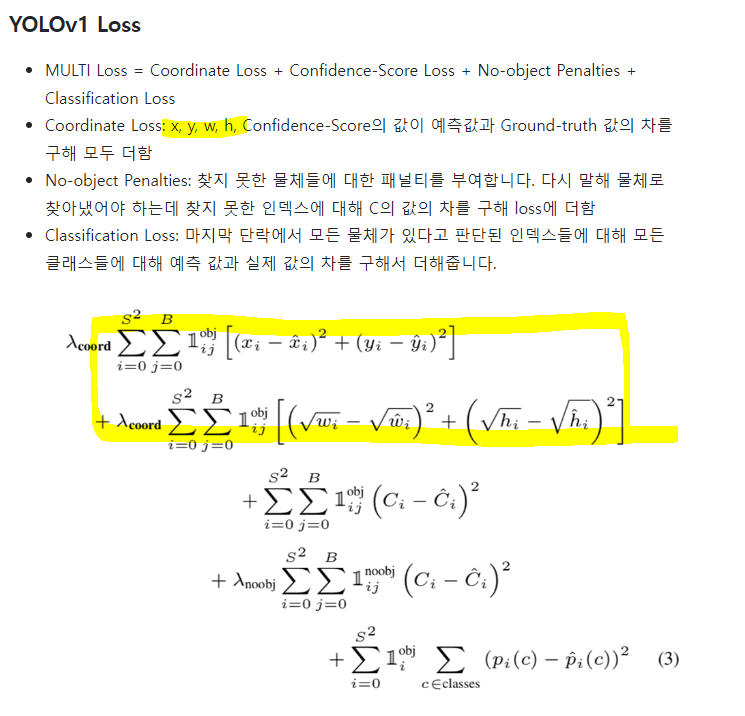

In [2]:
class car_data_set():
    def __init__(self, data_dir, phase, csv_data, transformer = None):
        self.csv_data = csv_data
        self.phase_data_dir = (data_dir + phase + '/')
        self.data_list = os.listdir(self.phase_data_dir)
        self.transformer = transformer

    def __len__(self):
        return len(self.data_list)
    
    def get_label_def(self, image_name):
        label = self.csv_data.loc[(self.csv_data['ImageID'] == image_name.split(".")[0])]
        target_name = [Class_Name_To_Int[i] for i in label['LabelName'].values]
        bounding_box = label.drop(columns = ['ImageID', 'LabelName']).values
        bounding_box[:, 2:4] -= bounding_box[:, 0:2]
        bounding_box[:, 0:2] += (bounding_box[:, 2:4] / 2)

        return target_name, bounding_box
    
    def get_image_def(self, image_name):
        image = cv2.imread(self.phase_data_dir + image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        return image
    

    def __getitem__(self, index):
        image_name = self.data_list[index]
        
        image = self.get_image_def(image_name)
        target_name, bboxes = self.get_label_def(image_name)

        if self.transformer:
            transformed_data = self.transformer(image=image, bboxes=bboxes, class_ids=target_name)
            image = transformed_data['image']
            bboxes = transformed_data['bboxes']
            class_ids = np.array(transformed_data['class_ids'])
        
        target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1)
        return image, target, image_name

In [3]:
transformer = A.Compose([
    A.Resize(height=448,width=448),
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    ],
    bbox_params = A.BboxParams(format='yolo', label_fields=['class_ids']),
)

def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []

    for a,b,c in batch:
        image_list.append(a)
        target_list.append(b)
        filename_list.append(c)

    return torch.stack(image_list, dim=0), target_list, filename_list

def build_dataloader(data_dir,csv_data,BATCH_SIZE ):
    dataloaders = {}
    train_data_set = car_data_set(data_dir=data_dir, phase='train', csv_data=csv_data, transformer=transformer)
    val_data_set = car_data_set(data_dir=data_dir, phase='val', csv_data=csv_data, transformer=transformer)

    dataloaders['train'] = DataLoader(train_data_set,batch_size = BATCH_SIZE ,shuffle=True,num_workers=12, pin_memory=True,collate_fn=collate_fn)
    dataloaders['val'] = DataLoader(val_data_set,batch_size = BATCH_SIZE ,shuffle=False, num_workers=12, pin_memory=True, collate_fn=collate_fn)
    return dataloaders

# 모델

In [4]:
class YOLOv1_RESNET(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        num_classes = num_classes
        num_boxes = 2
        grid_size = 7

        resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        layers = [m for m in resnet18.children()]

        self.backbone = nn.Sequential(*layers[:-2])

        self.head = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=1024, out_channels=(4+1)*num_boxes + num_classes, kernel_size=1, padding=0, bias=False),
            nn.AdaptiveAvgPool2d(output_size=(grid_size, grid_size))
        )
    
    def forward(self, x):
        out = self.backbone(x)
        out = self.head(out)
        return out

# yolo loss function구현

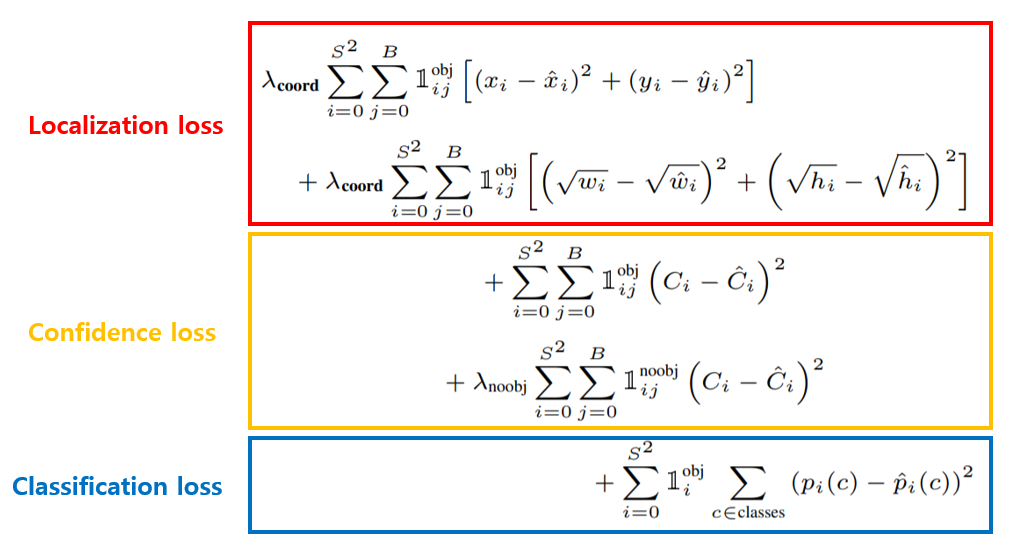

In [5]:
class YOLOv1_Loss():
    #파라미터에 lambda는 진짜 공식에 람다 파라미터 학습률 같은 개념으로 이해하였다.
    def __init__(self, num_classes, device, lambda_coord =5., lambda_noobj=0.5):
        self.num_classes = num_classes
        self.device = device
        self.grid_size = 7
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse_loss = nn.MSELoss(reduction='sum')

    def __call__(self, predictions, targets):
        self.batch_size, _, _, _ = predictions.shape
        groundtruths = self.build_batch_target_grid(targets)
        groundtruths = groundtruths.to(self.device)

        with torch.no_grad():
            #버스 전용 iou계산해서 7*7grid중에 정답값과 iou가 높은지 보여준다.
            iou1 = self.get_IoU(predictions[:, 1:5, ...], groundtruths[:, 1:5, ...])
            #트럭 전용 iou계산
            iou2 = self.get_IoU(predictions[:, 6:10, ...], groundtruths[:, 1:5, ...])
        #버스와 트럭iou계산 값을 한곳에 몰아준다.
        ious = torch.stack([iou1, iou2], dim=1)
        #.max를 사용하여 dim=1=>2번째 차원에서의 최대값의 인덱스값과 최대값을 저장(dim=1이라는거는 버스와 트럭 둘다 본다는 말이다.) 
        # max_iou에는iou최대값, best_box에는 그 인덱스값이 저장된다.
        max_iou, best_box = ious.max(dim=1, keepdim=True)

        #위에서 max_iou값이 [batch, 1, grid_size, grid_size]로 나오는데 나중을 위해서 두개를 합쳐 [batch, 2, grid_size, grid_size]로 만든다.
        max_iou = torch.cat([max_iou, max_iou], dim=1)
        #인덱스 중에 버스인것과 트럭인것의 인덱스 값을 bestbox에 넣는다.
        best_box = torch.cat([best_box.eq(0), best_box.eq(1)], dim=1)

        #나중에 loss를 계산하기 편하게 하기 위해서 아래처럼 10개를 2,5로 나눠서 차원을 늘리는 작업이다.
        predictions_ = predictions[:, :5*2, ...].reshape(self.batch_size, 2, 5, self.grid_size, self.grid_size)
        obj_pred = predictions_[:, :, 0, ...]
        xy_pred = predictions_[:, :, 1:3, ...]
        wh_pred = predictions_[:,:,3:5, ...]
        cls_pred = predictions[:,5*2:, ...]

        #정답 값도 위에 예측값과 비교하기 편하게 5개를 1,5로 차원을 늘리는 작업이다.
        groundtruths_ = groundtruths[:, :5, ...].reshape(self.batch_size, 1, 5, self.grid_size, self.grid_size)
        obj_target = groundtruths_[:, :, 0, ...]
        xy_target = groundtruths_[:, :, 1:3, ...]
        wh_target= groundtruths_[:, :, 3:5, ...]
        cls_target = groundtruths[:, 5:, ...]

        # 이부분은 (실제로 이쪽에 정답값이 있는지) * (예측 했을때 나온 예측값이 버스인지, 트럭인지) =  그 위치에 타겟값을 만들어낸다.
        positive = obj_target * best_box

        #공식의 localization loss구하는 식
        xy_loss = self.mse_loss(positive.unsqueeze(dim=2) * xy_pred, positive.unsqueeze(dim=2) * xy_target)
        wh_loss = self.mse_loss(positive.unsqueeze(dim=2) * (wh_pred.sign() * (wh_pred.abs() + 1e-8).sqrt()),
                        positive.unsqueeze(dim=2) * (wh_target + 1e-8).sqrt())
        #공식의 confidence loss구하는 식
        obj_loss = self.mse_loss(positive * obj_pred, positive * ious)
        noobj_loss = self.mse_loss((1 - positive) * obj_pred, ious*0)
        #classification loss구하는 식
        cls_loss = self.mse_loss(obj_target * cls_pred, cls_target)

        #마지막 loss정리
        obj_loss /= self.batch_size
        noobj_loss /= self.batch_size
        bbox_loss = (xy_loss+wh_loss) / self.batch_size
        cls_loss /= self.batch_size
        
        total_loss = obj_loss + self.lambda_noobj*noobj_loss + self.lambda_coord*bbox_loss + cls_loss
        return total_loss, (obj_loss.item(), noobj_loss.item(), bbox_loss.item(), cls_loss.item())

        
    def get_IoU(self, cbox1, cbox2):
        # predict하면 나오는 값이 grid_n번째 위치에서 x_center, y_center, w, h였다.
        # 그러다 보니 이거를 절대적인 위치에서 x_min, y_min, x_max, y_max로 바꿔줘야 IOU를 계산 가능하다.
        box1 = self.xywh_to_xyxy(cbox1)
        box2 = self.xywh_to_xyxy(cbox2)

        #구한 바운딩박스로 union즉 합집합을 구하기 위해 2개의 box의 x_max, y_max중 작은값, x_min,y_min중 큰값 가져온다.
        x1 = torch.max(box1[:, 0, ...], box2[:, 0, ...])
        y1 = torch.max(box1[:, 1, ...], box2[:, 1, ...])
        x2 = torch.min(box1[:, 2, ...], box2[:, 2, ...])
        y2 = torch.min(box1[:, 3, ...], box2[:, 3, ...])

        #그다음 위에서 구한 교집합의 좌표값으로 교집합사이즈를 구한다.
        intersection = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0)
        # 이후 cbox1, cbox2 원본에서 w,h를가지고 전체상자의 넓이- 교집합 사이즈를해서 합집합union을 찾는다.
        union = abs(cbox1[:, 2, ...]*cbox1[:, 3, ...]) + \
                abs(cbox2[:, 2, ...]*cbox2[:, 3, ...]) - intersection

        #gt를 사용해서 배치 안에 '0'보다 큰값이 있는가? 한마디로 교집합이 있는지? 
        # 만약에 있다면 얼만큼 교집되어있는지를 저장해서 보내준다.
        intersection[intersection.gt(0)] = intersection[intersection.gt(0)] / union[intersection.gt(0)]
        return intersection

    #하나의 타겟값을 만들어줌
    def build_target_grid(self, target):
        target_grid = torch.zeros((1 + 4 + self.num_classes, self.grid_size, self.grid_size), device=self.device)

        for gt in target:
            xc, yc, w, h, cls_id = gt
            x_grid_center = (xc % (1/self.grid_size)) #그리드로 나누고 그 안에 위치
            y_grid_center = (yc % (1/self.grid_size))
            cls_id = int(cls_id)

            x_grid_number = int(xc * self.grid_size) #몇번째 그리드 인지
            y_grid_number = int(yc * self.grid_size)
            target_grid[0, x_grid_number,y_grid_number] = 1
            target_grid[1:5, x_grid_number, y_grid_number] = torch.Tensor([x_grid_center, y_grid_center, w, h])
            target_grid[5+cls_id, x_grid_number, y_grid_number] = 1
        
        return target_grid

    #만약에 배치형태라면 배치만큼 배치 각각 만들어줘야하니깐
    def build_batch_target_grid(self, targets):
        target_grid_batch = torch.stack([self.build_target_grid(target) for target in targets], dim=0)
        return target_grid_batch

    def generate_xy_normed_grid(self, grid_size):
        #(grid_size,grid_size)크기의 meshgrid를 하게되면 만들수 있는 모든 조합을 만들어준다.
        y_offset, x_offset = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size), indexing="xy")
        xy_grid = torch.stack([x_offset, y_offset], dim=0)
        #한곳에 모은것을 grid_size로 나눠주면 grid별로 포지션값? 이 완성이된다.
        xy_normed_grid = xy_grid / grid_size
        return xy_normed_grid.to(self.device)

    def xywh_to_xyxy(self, bboxes):
        num_batch, _, grid_size, grid_size = bboxes.shape
        # grid_n번째 위치에서 x_center, y_center, w, h를 절대적인 위치에서 x_center, y_center, w, h로 바꿔주는 작업이다.
        xy_normed_grid = self.generate_xy_normed_grid(grid_size=grid_size)
        #완성된 grid별 포지션값을 tile을 써서 num_Batch사이즈만큼 늘려준다.
        # 이후에 grid별 위치의 x_center, y_center에 더해준다.
        xcyc = bboxes[:,0:2,...] + xy_normed_grid.tile(num_batch, 1,1,1)
        #W, H값도 가져와서 작업을해주면 xmin, ymin, xmax, ymax를 만들수가 있다.
        wh = bboxes[:,2:4,...]
        x1y1 = xcyc - (wh/2)
        x2y2 = xcyc + (wh/2)
        return torch.cat([x1y1,x2y2], dim=1)

# epoch설정

In [6]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
    train_loss = defaultdict(float)
    val_loss = defaultdict(float)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        elif phase == 'val':
            model.eval()
        
        running_loss = defaultdict(float)
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0].to(device)
            targets = batch[1]
            
            with torch.set_grad_enabled(phase == 'train'):
                predictions = model(images)
            loss, (obj_loss, noobj_loss, bbox_loss, cls_loss) = criterion(predictions, targets)

            if phase =='train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss["total_loss"] += loss.item()
                running_loss["obj_loss"] += obj_loss
                running_loss["noobj_loss"] += noobj_loss
                running_loss["bbox_loss"] += bbox_loss
                running_loss["cls_loss"] += cls_loss
                
                train_loss["total_loss"] += loss.item()
                train_loss["obj_loss"] += obj_loss
                train_loss["noobj_loss"] += noobj_loss
                train_loss["bbox_loss"] += bbox_loss
                train_loss["cls_loss"] += cls_loss
                
                if (index > 0) and (index % VERBOSE_FREQ) == 0:
                    text = f"iteration:[{index}/{len(dataloaders[phase])}] - "
                    for k, v in running_loss.items():
                        text += f"{k}: {v/VERBOSE_FREQ:.4f}  "
                        running_loss[k] = 0.
                    print(text)
            else: 
                val_loss["total_loss"] += loss.item()
                val_loss["obj_loss"] += obj_loss
                val_loss["noobj_loss"] += noobj_loss
                val_loss["bbox_loss"] += bbox_loss
                val_loss["cls_loss"] += cls_loss
    
    for k in train_loss.keys():
        train_loss[k] /= len(dataloaders['train'])
        val_loss[k] /= len(dataloaders['val'])
    return train_loss, val_loss


# 시작 파라미터 설정

In [7]:
data_dir = '/home/hts/A_project/hts_pytorch/data/DRIVING-DATASET/Detection/'
train_data_dir = os.path.join(data_dir, 'train/')
val_data_dir = os.path.join(data_dir, 'val/')

csv_data = pd.read_csv(data_dir + 'df.csv')
csv_data = csv_data.drop(columns=['Source', 'Confidence','IsOccluded','IsTruncated','IsGroupOf','IsDepiction','IsInside','XClick1X','XClick2X','XClick3X','XClick4X','XClick1Y','XClick2Y','XClick3Y','XClick4Y'])
csv_data = csv_data[['ImageID', 'LabelName', 'XMin', 'YMin', 'XMax', 'YMax']]
train_data_list = os.listdir(train_data_dir)
val_data_list = os.listdir(val_data_dir)

Class_Name_To_Int = {'Bus':0, 'Truck':1}
Int_To_Class_Name = {0:'Bus', 1:'Truck'}

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
NUM_CLASSES = 2
VERBOSE_FREQ = 10
BATCH_SIZE = 200

dataloaders = build_dataloader(data_dir=data_dir, csv_data=csv_data, BATCH_SIZE=BATCH_SIZE)
model = YOLOv1_RESNET(num_classes=NUM_CLASSES).to(device)
criterion = YOLOv1_Loss(num_classes=NUM_CLASSES, device=device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay=5e-4)

# 학습

In [8]:
num_epochs = 100

best_epoch = 0
best_score = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, val_loss = train_one_epoch(dataloaders, model, criterion, optimizer, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"epoch:{epoch+1}/{num_epochs} - Train Loss: {train_loss['total_loss']:.4f}, Val Loss: {val_loss['total_loss']:.4f}")
    
    if (epoch+1) % 10 == 0:
        os.makedirs('./trained_model/', exist_ok=True)
        torch.save(model, os.path.join('./trained_model/','bestmodel.pt'),_use_new_zipfile_serialization=False)

iteration:[10/69] - total_loss: 8.8975  obj_loss: 0.2062  noobj_loss: 7.0557  bbox_loss: 0.7346  cls_loss: 1.4904  
iteration:[20/69] - total_loss: 5.6324  obj_loss: 0.1590  noobj_loss: 4.4531  bbox_loss: 0.4437  cls_loss: 1.0284  
iteration:[30/69] - total_loss: 5.0608  obj_loss: 0.1553  noobj_loss: 3.9914  bbox_loss: 0.4079  cls_loss: 0.8701  
iteration:[40/69] - total_loss: 4.8102  obj_loss: 0.1482  noobj_loss: 3.6833  bbox_loss: 0.4048  cls_loss: 0.7963  
iteration:[50/69] - total_loss: 4.5332  obj_loss: 0.1492  noobj_loss: 3.4332  bbox_loss: 0.3793  cls_loss: 0.7708  
iteration:[60/69] - total_loss: 4.3570  obj_loss: 0.1461  noobj_loss: 3.2449  bbox_loss: 0.3738  cls_loss: 0.7195  
epoch:1/100 - Train Loss: 5.3130, Val Loss: 4.1103
iteration:[10/69] - total_loss: 4.1407  obj_loss: 0.1598  noobj_loss: 3.2357  bbox_loss: 0.3290  cls_loss: 0.7182  
iteration:[20/69] - total_loss: 3.6727  obj_loss: 0.1480  noobj_loss: 2.8124  bbox_loss: 0.2931  cls_loss: 0.6531  
iteration:[30/69] - t

/home/hts/.conda/envs/hts_car/lib/python3.8/site-packages/torch/serialization.py:652: UserWarning: Couldn't retrieve source code for container of type YOLOv1_RESNET. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


iteration:[10/69] - total_loss: 1.7835  obj_loss: 0.2067  noobj_loss: 1.1106  bbox_loss: 0.1163  cls_loss: 0.4403  
iteration:[20/69] - total_loss: 1.6417  obj_loss: 0.1844  noobj_loss: 1.0006  bbox_loss: 0.1055  cls_loss: 0.4297  
iteration:[30/69] - total_loss: 1.6500  obj_loss: 0.1957  noobj_loss: 0.9891  bbox_loss: 0.1073  cls_loss: 0.4234  
iteration:[40/69] - total_loss: 1.6084  obj_loss: 0.1939  noobj_loss: 0.9828  bbox_loss: 0.1039  cls_loss: 0.4036  
iteration:[50/69] - total_loss: 1.6288  obj_loss: 0.1892  noobj_loss: 0.9784  bbox_loss: 0.1049  cls_loss: 0.4259  
iteration:[60/69] - total_loss: 1.6402  obj_loss: 0.1890  noobj_loss: 0.9626  bbox_loss: 0.1099  cls_loss: 0.4204  
epoch:11/100 - Train Loss: 1.6318, Val Loss: 2.2245
iteration:[10/69] - total_loss: 1.7276  obj_loss: 0.2051  noobj_loss: 1.0432  bbox_loss: 0.1115  cls_loss: 0.4436  
iteration:[20/69] - total_loss: 1.5471  obj_loss: 0.1941  noobj_loss: 0.9398  bbox_loss: 0.0984  cls_loss: 0.3911  
iteration:[30/69] - 

# 테스트

In [13]:
def process_image(image_path):
    # Load the pre-trained model
    test_model = torch.load('./trained_model/bestmodel.pt')
    test_model.eval().to('cpu')

    # Define the transformation
    test_transformer = A.Compose([
        A.Resize(height=448, width=448),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    # Read and transform the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed_image = test_transformer(image=image)

    # Make predictions
    with torch.no_grad():
        predictions = test_model(transformed_image['image'].unsqueeze(dim=0))

    # Process predictions
    prediction = predictions.detach().cpu().squeeze(dim=0)
    grid_size = prediction.shape[-1]
    y_grid, x_grid = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size), indexing='xy')
    stride_size = 448/grid_size
    conf = prediction[[0,5], ...].reshape(1, -1)
    xc = (prediction[[1,6], ...] * 448 + x_grid*stride_size).reshape(1,-1)
    yc = (prediction[[2,7], ...] * 448 + y_grid*stride_size).reshape(1,-1)
    w = (prediction[[3,8], ...] * 448).reshape(1,-1)
    h = (prediction[[4,9], ...] * 448).reshape(1,-1)
    cls = torch.max(prediction[10:, ...].reshape(2, -1), dim=0).indices.tile(1,2)

    x_min = xc - w/2
    y_min = yc - h/2
    x_max = xc + w/2
    y_max = yc + h/2

    prediction_res = torch.cat([x_min, y_min, x_max, y_max, conf, cls], dim=0)
    prediction_res = prediction_res.transpose(0,1)
    conf_thres = 0.2
    pred_res = prediction_res[prediction_res[:, 4] > conf_thres]
    iou_threshold = 0.1
    nms_index = torchvision.ops.nms(boxes=pred_res[:, 0:4], scores=pred_res[:, 4], iou_threshold=iou_threshold)
    pred_res_ = pred_res[nms_index].numpy()
    image = cv2.resize(image, dsize=(448, 448))

    n_obj = pred_res_.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
    bboxes[:, 0:2] = (pred_res_[:, 0:2] + pred_res_[:, 2:4]) / 2
    bboxes[:, 2:4] = pred_res_[:, 2:4] - pred_res_[:, 0:2]
    class_ids = pred_res_[:, 5]

    # Display results
    print(image.shape)
    print(bboxes, class_ids)

    fig, ax = plt.subplots()
    image = cv2.resize(image, (448,448))
    ax.imshow(image)
    Int_To_Class_Name = {0: 'Bus', 1: 'Truck'}
    boundingbox = pred_res_[:, 0:4]

    for bbox, target in zip(boundingbox, targetname):
        xmin = max(0, min(bbox[0], 448))
        ymin = max(0, min(bbox[1], 448))
        xmax = max(0, min(bbox[2], 448))
        ymax = max(0, min(bbox[3], 448))
        target = Int_To_Class_Name[target]
        ax.text(xmin, ymin, target, color='red')
        ax.add_patch(patches.Rectangle((xmin,ymin), xmax-xmin, ymax-ymin,
                    fill=False,
                    edgecolor='red',
                    linewidth=1))

    plt.show()




In [14]:
val_path = '/home/hts/A_project/hts_pytorch/data/DRIVING-DATASET/Detection/val/'
val_list = os.listdir('/home/hts/A_project/hts_pytorch/data/DRIVING-DATASET/Detection/val/')

@interact(index=(0, len(val_list)-1))
def show_result(index=0):
    image_path = val_path + val_list[index]
    process_image(image_path)

interactive(children=(IntSlider(value=0, description='index', max=1521), Output()), _dom_classes=('widget-inte…